<a href="https://colab.research.google.com/github/cwenger91/LiDAR_Classification_DL/blob/main/ELEV_Class_Prediction_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIDAR Packet Info

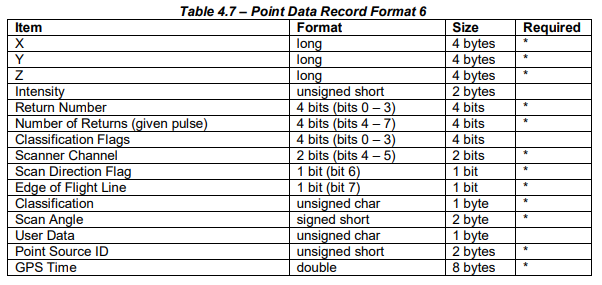

LIDAR Info
Classification values:


*   0: Created
*   1: Unclassified
*   2: Ground
*   3: Low Vegetation
*   4:  Medium Vegetation
*   5 High Vegetation
*   6 Building
*   7 Low Point (“low noise”)
*   8 High Point (typically “high noise”). Note that this 
*   9 Water
*   10 Rail
*   11 Road Surface
*   12 Bridge Deck
*   13 Wire - Guard
*   14 Wire – Conductor (Phase)
*   15 Transmission Tower
*   16 WIre-structure Connector (e.g. Insulator)
*   17 Reserved
*   18-63 Reserved



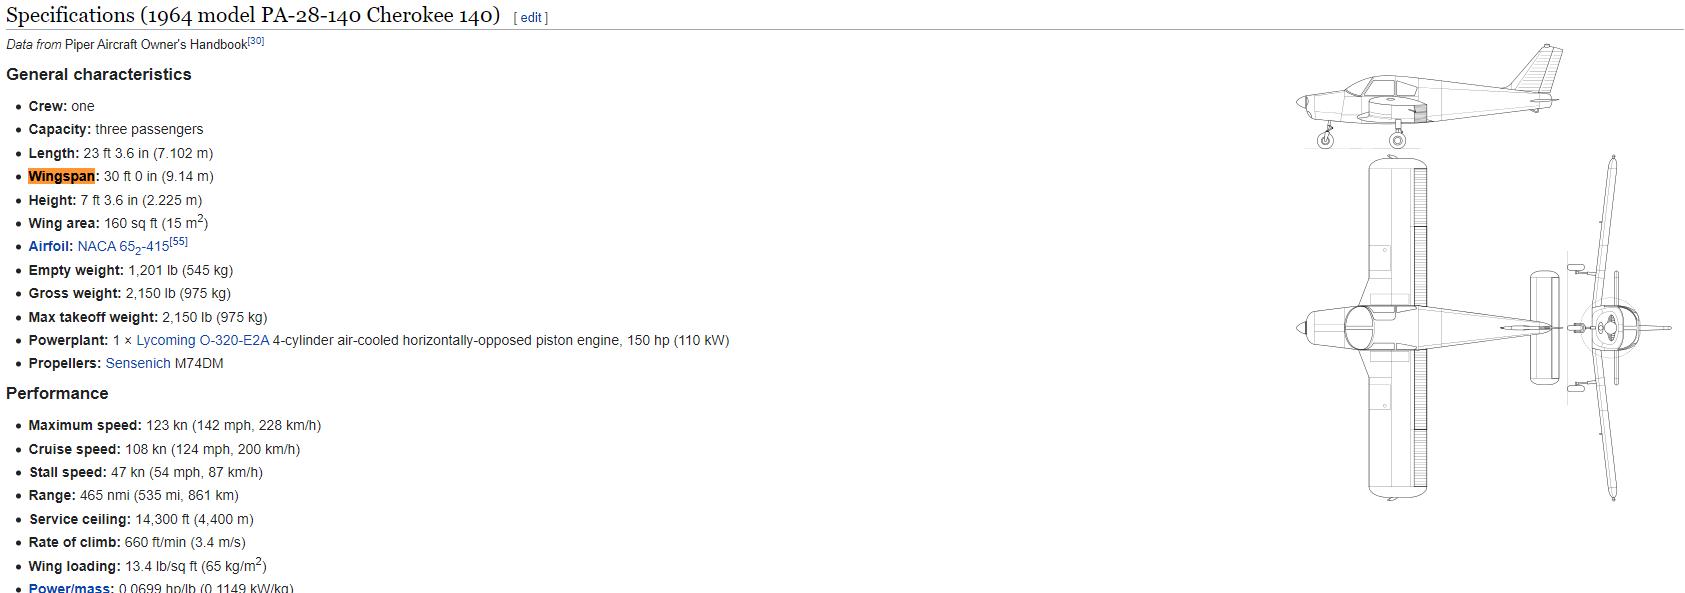

In [15]:
#Define the emergency landing area for the PA-28-140
EL_LENGTH = 200 # ft
EL_WIDTH = 40 #ft
LIDAR_SIZE = (2000,2000) #specified as 2000 ft by 2000 ft tiling scheme
NUM_LAS_POINTS = 50000 # Maximum number of points based on the smallest LIDAR file size
NUM_POINTS = 69717 # This constant was calculated by using EL_LENGTH/ LIDAR_SIZE[0]/# points
BATCH_SIZE = 32
DEBUG = 0  #Debug flag for development

In [16]:
## INSTALL Manual python-site packages
!pip install laspy
# !pip install open3d # Not Used yet
## IMPORT python-site packages
import urllib.request
from zipfile import ZipFile
import os
import glob
import pathlib
import tensorflow as tf
from laspy.file import File
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# import open3d as o3d #Not Used yet
from google.colab import drive
#Mount google drive that contains smaller dataset of the LIDAR Files over Peroria
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).



*   -Peroria_LIDAR_Files
*    --train
*      ---20 .las files
*    --test
*    ---20 .las files

In [17]:
LidarDataSet = '/gdrive/MyDrive/Peoria_LIDAR_Files.zip'

In [5]:
## Returns the scaled [x,y,z] points
## Based on the data taken by Illinois Department of Transportation District 4, Peoria County
# INPUT:
# 1) LASer format file <filename>.las
# OUTPUT:
# 1) Ranks 4 Tensor [x-coordinate,y-coordinate,z-coordinate,Classification]
def get_points(lasfile):
  points_tf = tf.constant([lasfile.x[0:NUM_LAS_POINTS],lasfile.y[0:NUM_LAS_POINTS],lasfile.z[0:NUM_LAS_POINTS],lasfile.Classification[0:NUM_LAS_POINTS]],dtype=tf.float64,shape=(4,NUM_LAS_POINTS))
  #ymap_tf = tf.constant(lasfile.y[I],dtype=float,shape=(len(lasfile.y[I])))
  #zmap_tf = tf.constant(lasfile.z[I],dtype=float,shape=(len(lasfile.z[I])))
  return points_tf

In [6]:
# Split the LAS Point Cloud packets into two tensors to be loaded into the dataset
# This removes extra noise that is stored in the point Cloud for LAS files
# INPUTS:
#   1) Ranks 4 Tensor [x-coordinate,y-coordinate,z-coordinate,Classification]
# OUTPUTS: 
#   1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
#   2) Ranks 1 Tensor [Classification]
def split_image_label(points_tf):
  return tf.constant(points_tf[0:3,:]), tf.constant(points_tf[3,:])

In [7]:
# Sample a small section of the las point cloud data
# INPUTS:
#   1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
#   2) Ranks 1 Tensor [Classification]
#   3) Scalar value [index location where sample will occur]
# OUTPUTS: 
#   1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
#   2) Ranks 1 Tensor [Classification]
def sample_point(points_tf,label,seed):
  unique_x, idx = tf.unique(points_tf[0])
  valid_idx = tf.where(tf.less(idx+NUM_POINTS,NUM_LAS_POINTS))
  lower = valid_idx[seed]
  upper = valid_idx[seed]+NUM_POINTS
  sample_points = points_tf[0][lower[0]:upper[0]], points_tf[1][lower[0]:upper[0]], points_tf[2][lower[0]:upper[0]]
  sample_label = label[lower[0]:upper[0]]
  return sample_points,sample_label


In [22]:
# Makes the lowest positive value 0
# This allows us to analysis 0 as ground level
# INPUT: 
# 1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
# OUTPUT: 
# Rank 3 Tensor [x-coordinate,y-coordinate,z-coordinate] all x-y-z points lowest value is 0
def level_points(points_tf,label):
  return [points_tf[0],points_tf[1],tf.subtract(points_tf[2],tf.reduce_min(points_tf[2]))],label


In [9]:
# Get the minimum point value used to reduce points to ground level
# INPUT: 
# 1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
# 2) Rank 1 Tensor [classification]
# OUTPUT: 
# 1) Rank 3 Tensor [MIN(x-coordinate),MIN(y-coordinate),MIN(z-coordinate)]
# 2) Rank 1 Tensor [classification]
def get_reducing_factors(points_tf,label):
  return tf.reduce_min(points_tf),label

In [10]:
# Normilize the data between [0:1]
# INPUT: 
# 1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
# 2) Rank 1 Tensor [classification]
# OUTPUT: 
# 1) Rank 3 Tensor [x-coordinate,y-coordinate,z-coordinate] normilized between [0:1]
# 2) Rank 1 Tensor [classification]
def normilize_points(points_tf,label):
  return tf.divide(points_tf,tf.reduce_max(points_tf)),label

In [27]:
# Create Train and Test Dataset from LASer files
# PROCESS:
# 1) Capture point data from LASer files in train and test folder
# 2) Sample small set of points around a unique_x value
# 3) Append Data to train/test point and labels
# INPUTS: 
# NONE
# OUTPUTS:
#   1) Train points dataset Rank 3 Tensor length is NUM_LAS_POINTS
#   2) Train labels dataset Rank 1 Tensor length is NUM_LAS_POINTS
#   3) Test points dataset Rank 3 Tensor length is NUM_LAS_POINTS
#   4) Test labels dataset Rank 1 Tensor length is NUM_LAS_POINTS
def parse_dataset():
  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  seed = []
  train_files = glob.glob("/content/Peoria_LIDAR_Files/train/*")
  test_files = glob.glob("/content/Peoria_LIDAR_Files/test/*")

  # Sample points from each LIDAR file in the train folder
  for f in train_files[0:10]:
    lasfileTrain = File(f, mode='r')
    points_tf,label = split_image_label(get_points(lasfileTrain))
    # Get a valid point within the bounds of a 200ft by 200ft image
    unique_x, idx = tf.unique(points_tf[0])
    valid_idx = tf.where(tf.less(idx+NUM_POINTS,NUM_LAS_POINTS))
    #Store seed values to ensure train and test use the same seed
    seed.append(random.randint(0,len(valid_idx)))
    #sample_points,sample_label = sample_point(points_tf,label,seed)
    train_points.append(points_tf)
    train_labels.append(label)
    seed_idx = 0
  # Sample points from each LIDAR file in the test folder
  for f in test_files[0:10]:
    lasfileTest = File(f, mode='r')
    points_tf,label = split_image_label(get_points(lasfileTest))
    #sample_points,sample_label = sample_point(points_tf,label,seed[seed_idx])
    test_points.append(points_tf)
    test_labels.append(label)
    seed_idx = seed_idx + 1
  return train_points, train_labels, test_points, test_labels

In [12]:
# This function adds some jitter to the points location and then shuffles points around in the dataset
# INPUTS:
#   1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
#   2) Ranks 1 Tensor [Classification]
# OUTPUTS: 
#   1) Ranks 3 Tensor [x-coordinate,y-coordinate,z-coordinate]
#   2) Ranks 1 Tensor [Classification]
def augment(points_tf,labels):
  # Add noise to points
  points_tf += tf.random.uniform(points_tf.shape,-0.005,0.005,dtype=tf.float64)
  # Shuffle points around
  points_tf = tf.random.shuffle(points_tf)
  return points_tf,labels

In [18]:

if not DEBUG:
  with ZipFile(LidarDataSet, 'r') as zip:
          zip.extractall()
else:
  lasfileTest = "/content/drive/MyDrive/2342_1438.las"
  inFile = File(lasfileTest, mode='r')
  points = get_points(inFile)

In [28]:
if DEBUG:
  xyz_coords,label = split_image_label(points)
  #print(xyz_coords[0])
  seed = random.randint(0,len(valid_idx))
  print(level_points(xyz_coords))
  sample_xyz,sample_label = sample_point(xyz_coords,label,seed)
  print(sample_xyz[2])
  print(sample_label)
  ax = plt.axes(projection='3d')
  ax.scatter3D(sample_xyz[0],sample_xyz[1],sample_xyz[2])
else:
  train_points, train_labels, test_points, test_labels = parse_dataset()

  train_dataset = tf.data.Dataset.from_tensor_slices((train_points,train_labels))
  test_dataset = tf.data.Dataset.from_tensor_slices((test_points,test_labels))

  train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
  test_dataset = train_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

  train_dataset = train_dataset.map(level_points)
  train_dataset = train_dataset.map(normilize_points)

  test_dataset = test_dataset.map(level_points)
  test_dataset = test_dataset.map(normilize_points)